In [1]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpol
from pyccl._core import UnlockInstance

#from tqdm.notebook import tqdm

## Monday Week 1 (08/07/2024): Have to create a class for a bound mass profile
 - Look at https://github.com/LSSTDESC/CCL/blob/master/pyccl/halos/profiles/nfw.py as an example of the creation of a halo mass profile.
 - Python docs on classes: https://docs.python.org/3/tutorial/classes.html
 - Selected bits: 
   - the class inheritance mechanism allows multiple base classes
   - a derived class can override any methods of its base class or classes
   - a method can call the method of a base class with the same name

$\rho_X(r)\ = Ma ^{-3} f_X g_X(r)\$. 

- M = total halo mass
- $f_X$ = the fraction of that mass in gas species X
- $g(x)$ = the profile, which satisfies the normalisation $4\pi \int^{\infty}_0 dr\ r^2 g_X(r)\ = 1$
- a = the scale factor

$f_c + f_b + f_e + f_* = 1$ AND (assuming adiabaticity) $f_b + f_e + f_* = \bar{f}_b \equiv \frac{\Omega_b}{\Omega_M}$

----------------------------------------------------------------------------
In [paper](../Background-reading/XrayCrossCorrelations-1.pdf), see that:   
$\rho_x(r)\ = M f_x\ a^{-3} g_x(r)\ $    

$f_b(M) = []$   
$g_b(r)\ = \frac{1}{V_b} \left( \frac{log(1 + \frac{r}{r_s})}{\frac{r}{r_s}} \right)^{\frac{1}{\Gamma - 1}} $ , where $log \equiv ln$.    
$V_b \equiv 4\pi r_s^3 I_b(\frac{1}{\Gamma - 1}, 0)\ $   
$I_b(\gamma, q)\ = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\gamma} j_0(qx)\ $, with $ q = kr_s $ [in Fourier space].   
$\to I_b(\frac{1}{\Gamma - 1}, 0)\ = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}} j_0(0)\  = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}}$   
As $j_0 $ is a Besel function, & $j_0(0)\ = 1 $.

Therefore:   
$\rho_x(r)\ = \frac{M f_x\ }{4\pi r_s^3 a^{3}} \frac{1}{\int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}}} \left( \frac{log(1 + \frac{r}{r_s})}{\frac{r}{r_s}} \right)^{\frac{1}{\Gamma - 1}} $ 

$\tilde{g}_b(k)\ = \frac{I_b(1/(\Gamma - 1),q)\ }{I_b(1/(\Gamma - 1),0)\ } $ , with $q = kr_s$
- already have $I_b(1/(\Gamma - 1),0)\ $, so:
- need to write function for $I_b(1/(\Gamma - 1),q)\ $ (another interpolator)
- and, in _fourier function, call $\tilde{g}_b(k)\ $ for the particular (gamma, r_s) pars over k

In [344]:
class boundGas_profile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the bound gas density profile
    where: """  # could put in the equations used

    def __init__(self, mass_def, gamma, concentration, r_s=1, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64):
        #, # n_q/Gamma = 2^x
                # Omega_c = 0.25, Omega_b=0.05, h=0.07, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0):
        # will change later, but can leave characteristic scale as ~ 1 Mpc for the moment
        
        self.r_s = r_s 
        self.gamma = gamma
        super(boundGas_profile, self).__init__(mass_def=mass_def, concentration=concentration)

        self.GammaRange = GammaRange
        self.nGamma = nGamma

        self.qrange = qrange
        self.nq = nq
        
        self._func_normQ0 = None   # General normalised profile (for q=0, over Gamma)
        self._func_normQany = None

    def _shape(self, x, gam):
        gam_use = np.atleast_1d(gam)
        return (np.log(1+x)/x)**gam_use

    def _innerInt(self, x, gam): #(a, gam=1/(gamma_use-1), b=1, c=1):
        return x**2 * self._shape(x, gam)   # eqn = (1/c) * (a**2) * (np.log(1 + a/b)/(a/b))**gam

    import scipy.integrate as integrate
    import scipy.interpolate as interpol
    from pyccl._core import UnlockInstance

    def _Vb_prefix(self, r_s=1):
        vB1 = integrate.quad(self._innerInt, 0, np.inf, args = (1/(self.gamma-1)))  # (func, a, b[, args, full_output, ...])
        vB2 = 4*np.pi*(r_s**3)*vB1[0]
        return vB2

    def _norm_interpol1(self):  # interpol1 = for q = 0
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        I0_array = np.zeros(self.nGamma)
        k=0
        for i in gamma_list:
            I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
            k+=1
        func_normQ0 = interpol.interp1d(gamma_list, I0_array)
                  # =  interpol.interp1d(gamma_list, I0_array, kind='cubic') # interp1d(x, y, ...
        return func_normQ0
        
    def _real(self, r, M, call_interp=True, scale_a=1): 
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        
        R_M = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a # halo virial radius
        c_M = self.concentration(cosmo, M_use, scale_a) # concentration-mass relation c(M)
        r_s = R_M / c_M # characteristic scale r_s

        if call_interp==False:
            vB_prefix = self._Vb_prefix(r_s)
        else:
            if self._func_normQ0 is None: # is instead of == here
                with UnlockInstance(self):
                    self._func_normQ0 = self._norm_interpol1() 
            vB_prefix = 4*np.pi*(r_s**3)*self._func_normQ0(self.gamma)  # self._Vb_prefix(gamma_use, rS_use)[0]
        prefix = M_use * (1/scale_a**3) * (1/vB_prefix)
# Returns: float or array_like: halo profile. Shape of the output = `(N_M, N_r)` where `N_r` & `N_m` = the sizes of `r` & `M` respectively.

        x = r_use[None, :] / r_s[:, None]
        prof = prefix[:, None] * self._shape(x, 1/(self.gamma-1)) # default par of gam = 1/(gamma_use-1) #innerInt(x)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

    def _norm_interpol2(self):  # interpol1 for q = any
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        q_array = np.geomspace(self.qrange[0], self.qrange[1], self.nq) # q = k*r_s, k will be from geomspace
        I0_array =  np.zeros((self.nGamma, self.nq))

        def integralQany(x, gam): #(a, gam=1/(gamma_use-1), b=1, c=1):
            return x * self._shape(x, gam) # for q = any (& j0(qx) = sinh(qx) = sin(qx)/(qx) => int[x^2 ... j0] = int[x ... sin(qx)]/q
        k=0
        for i in gamma_list: 
            l=0
            for j in q_array: 
                I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j
                l+=1
            k+=1
            print(f'k = {100*k/self.nGamma:.3g}% through')
        #interpol.RegularGridInterpolator() for 2D array # (points, values, ... 
        func_normQany = interpol.RegularGridInterpolator((gamma_list, np.log(q_array)), I0_array)
        return func_normQany
    
    def _fourier(self, k, M, scale_a=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)

        R_M = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a # halo virial radius
        c_M = self.concentration(cosmo, M_use, scale_a) # concentration-mass relation c(M)
        r_s = R_M / c_M # characteristic scale r_s
        r_s = np.atleast_1d(r_s)

        if self._func_normQ0 is None: # is instead of == here
            with UnlockInstance(self):
                self._func_normQ0 = self._norm_interpol1() 
        if self._func_normQany is None:
            with UnlockInstance(self):
                self._func_normQany = self._norm_interpol2()

        q_use = k_use[None, :]*r_s[:, None]
        g_k = self._func_normQany((self.gamma, np.log(q_use))) / self._func_normQ0(self.gamma) # = Ib_qAny / Ib_q0

        prefix = M_use / scale_a**3
        prof = prefix[:, None] * g_k[None,:] 

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

# Real profiles for the bound gas
Characteristic scale $r_s$ should be ~ 1 Mpc (so leave as = 1), and gamma $\Gamma$ (which has no real physical significance, just a fitting number) should be around ~ 1.1-1.2 (but when doing normalisation interpolator, should do for $\Gamma \in [1.01,10]$ ).

In [348]:
trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_M = np.array([5E12,2E13, 1E14])
trial_gamma = 1.1 # np.array([2,3,4])
# working with z = 0 (today) ; therefore a = 1 [default]
hmd_200c = ccl.halos.MassDef200c # use a mass definition with Delta = 200
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200c)
cosmo = ccl.Cosmology(Omega_c = 0.25, Omega_b=0.05, h=0.07, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
bd_rsTrial = 1
trial_interpd_boundProf = boundGas_profile(hmd_200c, trial_gamma, cM)

In [350]:
profTrial_interpd_real = trial_interpd_boundProf._real(trial_r, trial_M, call_interp=True) 
# _real(self, r, M, call_interp=True, scale_a=1, f=1)
profTrial_interpd_real

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_11249/658058607.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_11249/658058607.py:44: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))


array([[7.75112664e+13, 7.75077801e+13, 7.75042931e+13, ...,
        7.70245792e-60, 7.68563560e-60, 7.66885001e-60],
       [5.95904297e+13, 5.95889051e+13, 5.95873802e+13, ...,
        1.31468588e-57, 1.31181916e-57, 1.30895870e-57],
       [4.19512342e+13, 4.19506809e+13, 4.19501274e+13, ...,
        5.07424639e-55, 5.06320375e-55, 5.05218514e-55]])

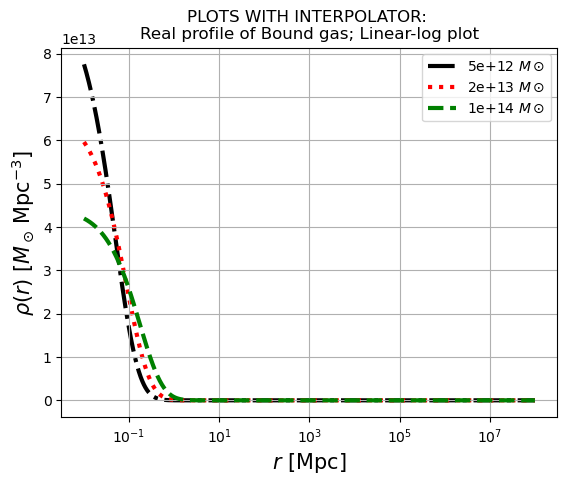

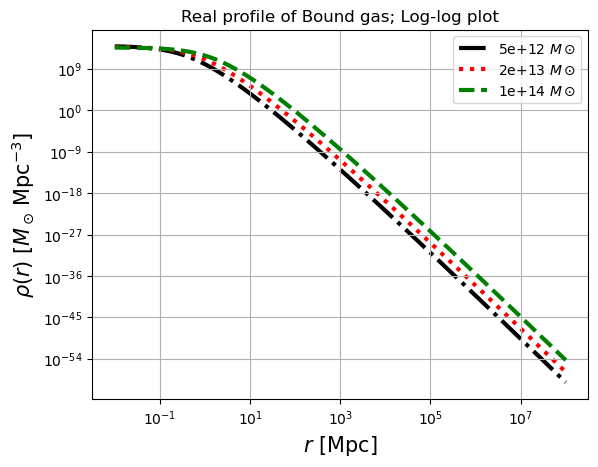

In [351]:
colours, i = ['k-.', 'r:', 'g--'], 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, profTrial_interpd_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('PLOTS WITH INTERPOLATOR: \nReal profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, profTrial_interpd_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Bound gas; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

In [353]:
profTrial_real = trial_interpd_boundProf._real(trial_r, trial_M, call_interp=False) # WITHOUT interpolator
# _real(self, r, M, call_interp=True, scale_a=1, f=1)
profTrial_real

array([[4.08734076e+14, 4.08715692e+14, 4.08697305e+14, ...,
        4.06167667e-59, 4.05280589e-59, 4.04395447e-59],
       [3.14233535e+14, 3.14225496e+14, 3.14217454e+14, ...,
        6.93262985e-57, 6.91751302e-57, 6.90242915e-57],
       [2.21218150e+14, 2.21215232e+14, 2.21212314e+14, ...,
        2.67576252e-54, 2.66993949e-54, 2.66412913e-54]])

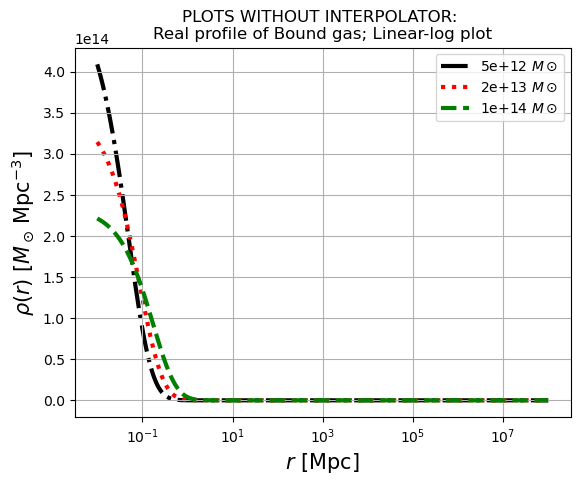

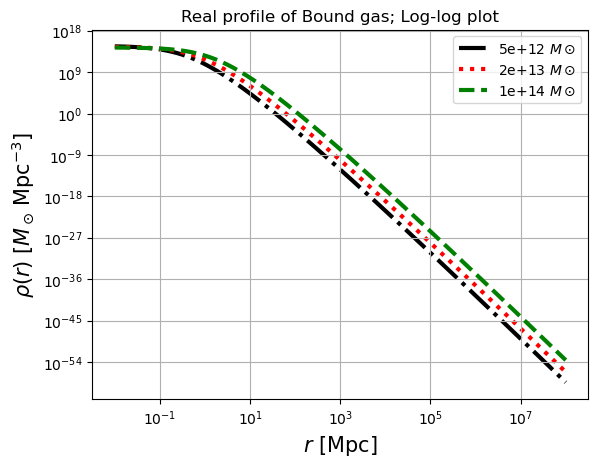

In [354]:
colours = ['k-.', 'r:', 'g--']
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i], colours[i], lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('PLOTS WITHOUT INTERPOLATOR: \nReal profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
#plt.xlim(1e-2,1e5);  #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i], colours[i], lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Bound gas; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');
#plt.xlim(1e-2,1e5);  #plt.ylim(1e-2,1e5);

## Comparing Real profile with & without interpolator

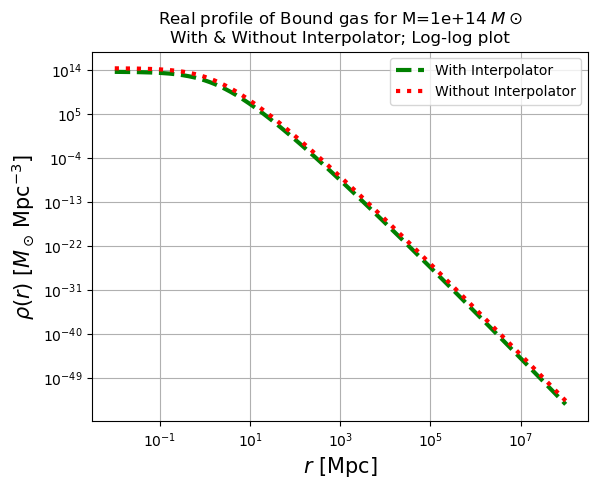

In [358]:
plt.plot(trial_r, profTrial_interpd_real[2], 'g--', lw=3, label='With Interpolator')
plt.plot(trial_r, profTrial_real[2], 'r:', lw=3, label='Without Interpolator')
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(f'Real profile of Bound gas for M={trial_M[2]:.1g} $M\\odot $\nWith & Without Interpolator; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log'); 

# Fourier profile for the bound gas 

In [361]:
trial_k = np.geomspace(1E-3,1E2,100000)
trial_M = np.array([5E12,2E13, 1E14])
profTrial_fourier = trial_interpd_boundProf._fourier(trial_k, trial_M)
profTrial_fourier  #_fourier(self, k, M, scale_a=1, f=1)

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_11249/658058607.py:25: RuntimeWarning: invalid value encountered in scalar divide
  return (np.log(1+x)/x)**gam_use
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_11249/658058607.py:89: IntegrationWarning: The maximum number of cycles allowed has been achieved., e.e.
  of subintervals (a+(k-1)c, a+kc) where c = (2*int(abs(omega)+1))
  *pi/abs(omega), for k = 1, 2, ..., lst.  One can allow more cycles by increasing the value of limlst.  Look at info['ierlst'] with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


k = 1.56% through


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_11249/658058607.py:89: IntegrationWarning: Bad integrand behavior occurs within one or more of the cycles.
  Location and type of the difficulty involved can be determined from 
  the vector info['ierlist'] obtained with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


k = 3.12% through
k = 4.69% through
k = 6.25% through
k = 7.81% through
k = 9.38% through
k = 10.9% through
k = 12.5% through
k = 14.1% through
k = 15.6% through
k = 17.2% through
k = 18.8% through
k = 20.3% through
k = 21.9% through
k = 23.4% through
k = 25% through
k = 26.6% through


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_11249/658058607.py:89: IntegrationWarning: The extrapolation table constructed for convergence acceleration
  of the series formed by the integral contributions over the cycles, 
  does not converge to within the requested accuracy.  Look at 
  info['ierlst'] with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


k = 28.1% through
k = 29.7% through
k = 31.2% through
k = 32.8% through
k = 34.4% through
k = 35.9% through
k = 37.5% through
k = 39.1% through
k = 40.6% through
k = 42.2% through
k = 43.8% through
k = 45.3% through
k = 46.9% through
k = 48.4% through
k = 50% through
k = 51.6% through
k = 53.1% through
k = 54.7% through
k = 56.2% through
k = 57.8% through
k = 59.4% through
k = 60.9% through
k = 62.5% through
k = 64.1% through
k = 65.6% through
k = 67.2% through
k = 68.8% through
k = 70.3% through
k = 71.9% through
k = 73.4% through
k = 75% through
k = 76.6% through
k = 78.1% through
k = 79.7% through
k = 81.2% through
k = 82.8% through
k = 84.4% through
k = 85.9% through
k = 87.5% through
k = 89.1% through
k = 90.6% through
k = 92.2% through
k = 93.8% through
k = 95.3% through
k = 96.9% through
k = 98.4% through
k = 100% through


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_11249/658058607.py:114: RuntimeWarning: overflow encountered in divide
  g_k = self._func_normQany((self.gamma, np.log(q_use))) / self._func_normQ0(self.gamma) # = Ib_qAny / Ib_q0
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_11249/658058607.py:117: RuntimeWarning: overflow encountered in multiply
  prof = prefix[:, None] * g_k[None,:]


array([[[4.99987255e+12, 4.99987255e+12, 4.99987254e+12, ...,
                    inf,            inf,            inf],
        [1.99994092e+13, 1.99994091e+13, 1.99994091e+13, ...,
                    inf,            inf,            inf],
        [9.99954212e+13, 9.99954207e+13, 9.99954203e+13, ...,
                    inf,            inf,            inf]]])

#### Normalisation of profiles means that:   
$\rho(k \to 0)\ _x = \frac{M_x}{a^3} [f_x]$   
#### So plotting $y = x + \frac{M_x}{a^3} [f_x]$ should give an overlap with the [normalised] Fourier density profile's plateau

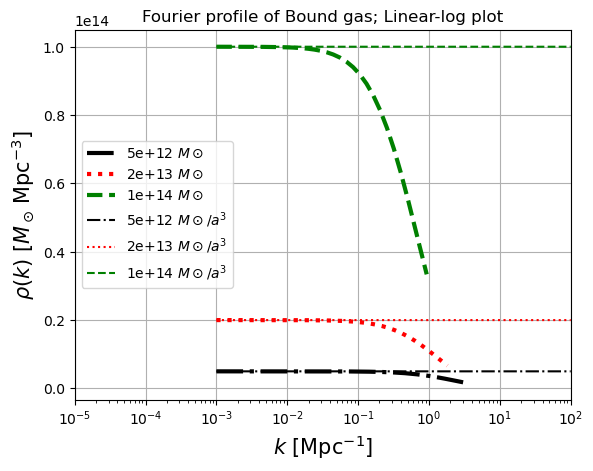

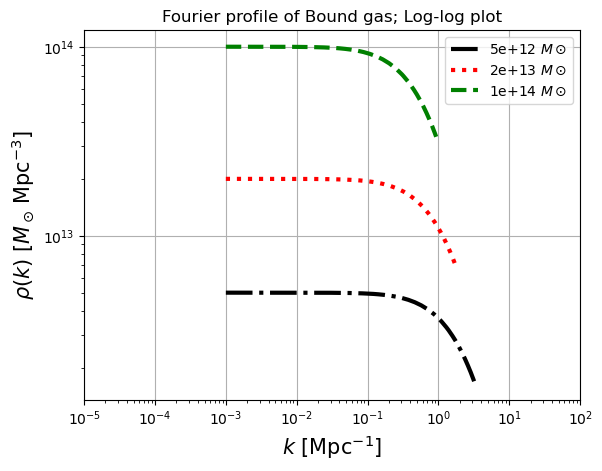

In [364]:
#### colours = ['k-.', 'r:', 'g--']
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[0,i], colours[i], lw=3, zorder = (10-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
for mass, col in zip(trial_M, colours):
    plt.plot(trial_k, 1*trial_k + mass, col, zorder=(10-i), label=f'{mass:.1g} $M \\odot /a^3$')  # here, a=1 & f=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title('Fourier profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.xlim(1e-5,1e2); #plt.ylim(1e-5,1e2);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[0,i], colours[i], lw=3, zorder = (10-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title('Fourier profile of Bound gas; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');
plt.xlim(1e-5,1e2); #plt.ylim(1e-5,1e2);

# Test my Fourier method against the Haloprofile [built-in] Fourier method

In [41]:
class bdProfile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the bound gas density profile
    where: """  # could put in the equations used

    def __init__(self, cosmo, mass_def, gamma, concentration, r_s=1, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64):
        self.cosmo = cosmo
        self.r_s = r_s 
        self.gamma = gamma
        super(bdProfile, self).__init__(mass_def=mass_def, concentration=concentration)

        self.GammaRange = GammaRange
        self.nGamma = nGamma

        self.qrange = qrange
        self.nq = nq
        
        self._func_normQ0 = None   # General normalised profile (for q=0, over Gamma)
        self._func_normQany = None

    def _shape(self, x, gam):
        gam_use = np.atleast_1d(gam)
        return (np.log(1+x)/x)**gam_use

    def _innerInt(self, x, gam): #(a, gam=1/(gamma_use-1), b=1, c=1):
        return x**2 * self._shape(x, gam)   # eqn = (1/c) * (a**2) * (np.log(1 + a/b)/(a/b))**gam

    def _Vb_prefix(self, r_s=1):
        vB1 = integrate.quad(self._innerInt, 0, np.inf, args = (1/(self.gamma-1)))  # (func, a, b[, args, full_output, ...])
        vB2 = 4*np.pi*(r_s**3)*vB1[0]
        return vB2

    def _norm_interpol1(self):  # interpol1 = for q = 0
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        I0_array = np.zeros(self.nGamma)
        k=0
        for i in gamma_list:
            I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
            k+=1
        func_normQ0 = interpol.interp1d(gamma_list, I0_array) # interp1d(x, y, ...
        return func_normQ0
        
    def _real(self, cosmo, r, M, call_interp=True, scale_a=1): 
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        
        R_M = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a # halo virial radius
        c_M = self.concentration(self.cosmo, M_use, scale_a) # concentration-mass relation c(M)
        r_s = R_M / c_M # characteristic scale r_s

        if call_interp==False:
            vB_prefix = self._Vb_prefix(r_s)
        else:
            if self._func_normQ0 is None: # is instead of == here
                with UnlockInstance(self):
                    self._func_normQ0 = self._norm_interpol1() 
            vB_prefix = 4*np.pi*(r_s**3)*self._func_normQ0(self.gamma)  # self._Vb_prefix(gamma_use, rS_use)[0]
        prefix = M_use * (1/scale_a**3) * (1/vB_prefix)
# Returns: float or array_like: halo profile. Shape of the output = `(N_M, N_r)` where `N_r` & `N_m` = the sizes of `r` & `M` respectively.

        x = r_use[None, :] / r_s[:, None]
        prof = prefix[:, None] * self._shape(x, 1/(self.gamma-1)) # default par of gam = 1/(gamma_use-1) #innerInt(x)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

In [43]:
ccl.halos.profiles.profile_base.HaloProfile.fourier

<function pyccl.halos.profiles.profile_base.HaloProfile.fourier(self, cosmo, k, M, a)>

In [45]:
bdProfile.fourier

<function pyccl.halos.profiles.profile_base.HaloProfile.fourier(self, cosmo, k, M, a)>

In [47]:
builtIn_trial = bdProfile(cosmo, hmd_200c, trial_gamma, cM)

In [49]:
bdProfile._real

<function __main__.bdProfile._real(self, cosmo, r, M, call_interp=True, scale_a=1)>

In [55]:
bdProfile_real = builtIn_trial._real(cosmo, trial_r, trial_M)#, call_interp=True) 

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4204/1839816723.py:37: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4204/1839816723.py:37: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))


In [96]:
cosmo

<pyccl.cosmology.Cosmology>
	A_s     = 2.1e-09
	Neff    = 0
	Omega_b = 0.05
	Omega_c = 0.25
	Omega_g = 0
	h       = 0.07
	n_s     = 0.96
	extra_parameters =
	HASH_ACCURACY_PARAMS = 0x8bd61b991b949d90

In [79]:
trial_k2 = np.geomspace(1E-3,1E-1,100000)
builtIn_fourier = builtIn_trial.fourier(cosmo, trial_k2, trial_M, 1)
# cosmo = ccl.Cosmology(Omega_c = 0.25, Omega_b=0.05, h=0.07, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
# profTrial_fourier = trial_interpd_boundProf._fourier(trial_k, trial_M)
# _real(self, r, M, call_interp=True, scale_a=1, f=1) #_fourier(self, k, M, scale_a=1, f=1)

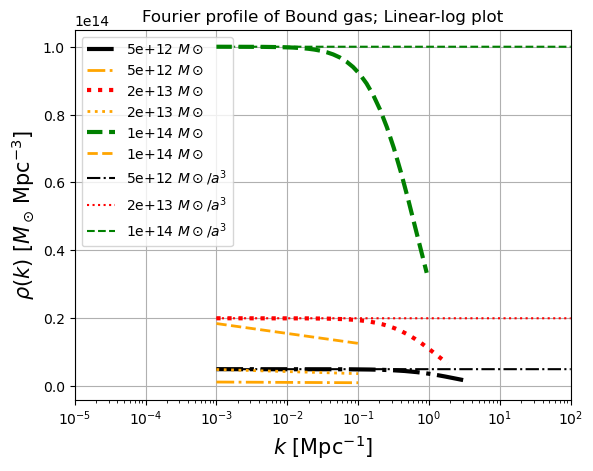

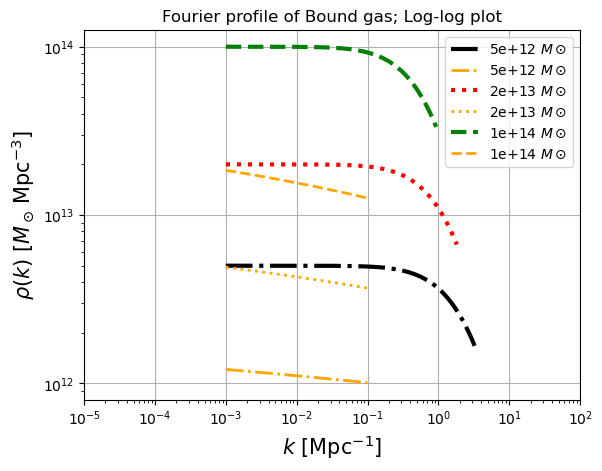

In [81]:
#### colours = ['k-.', 'r:', 'g--']
lines = ['-.',':','--']
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[0,i], colours[i], lw=3, zorder = (10-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    plt.plot(trial_k2, builtIn_fourier[i], color='orange', linestyle=lines[i], lw=2, zorder = (15-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
for mass, col in zip(trial_M, colours):
    plt.plot(trial_k, 1*trial_k + mass, col, zorder=(5-i), label=f'{mass:.1g} $M \\odot /a^3$')  # here, a=1 & f=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title('Fourier profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.xlim(1e-5,1e2); #plt.ylim(1e-5,1e2);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[0,i], colours[i], lw=3, zorder = (10-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    plt.plot(trial_k2, builtIn_fourier[i], color='orange', linestyle=lines[i], lw=2, zorder = (15-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title('Fourier profile of Bound gas; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');
plt.xlim(1e-5,1e2); #plt.ylim(1e-5,1e2);

# Checking the Interpolator of the imported class

In [22]:
import BCMprofiles_Copy2 as BCMprofiles
BCMprofiles.__all__

('StellarProfile',
 'EjectedGasProfile',
 'BoundGasProfile',
 'CombinedGasProfile',
 'CombinedStellarGasProfile',
 'CombinedAllBCMProfile')

In [261]:
# trial_gamma = 1.01

In [263]:
bd_profile = BCMprofiles.BoundGasProfile(cosmo, hmd_200c, cM, trial_gamma)
bd_profile_false = BCMprofiles.BoundGasProfile(cosmo, hmd_200c, cM, trial_gamma, fourier_analytic=False)

In [265]:
bd_real = bd_profile._real(cosmo, trial_r, trial_M)
bd_real_noInterp = bd_profile._real(cosmo, trial_r, trial_M, call_interp=False)

bd_real_false = bd_profile_false._real(cosmo, trial_r, trial_M)
bd_real_false_noInterp = bd_profile_false._real(cosmo, trial_r, trial_M, call_interp=False)

In [266]:
print('interpd: ', integrate.simpson(4*np.pi*(trial_r**2)*bd_real, x = trial_r)/trial_M)
print('no interpd: ', integrate.simpson(4*np.pi*(trial_r**2)*bd_real_noInterp, x = trial_r)/trial_M)

interpd:  [0.69843913 0.90359826 0.98097823]
no interpd:  [0.69843913 0.90359826 0.98097823]


In [267]:
bd_real_noInterp/bd_real

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_11249/3377281168.py:1: RuntimeWarning: invalid value encountered in divide
  bd_real_noInterp/bd_real


array([[ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan]])

In [217]:
gamma_array = np.arange(1.01, 8, 0.05)
prof_range = np.empty(np.shape(gamma_array))
prof_range2 = np.empty(np.shape(gamma_array))
for i, gam in enumerate(gamma_array):
    prof = BCMprofiles.BoundGasProfile(cosmo, hmd_200c, cM, gam)
    x = prof._real(cosmo, trial_r, trial_M)
    y = prof._real(cosmo, trial_r, trial_M, call_interp=False)
    z = y/x
    prof_range[i] = z[0,0]
    prof_range2[i] = np.mean(z)
    print(100*i/len(gamma_array), '%')
#prof_range = BCMprofiles.BoundGasProfile(cosmo, hmd_200c, cM, gamma_array)
#range_intp = prof_range._real(cosmo, trial_r, trial_M)
#range_noIntp = prof_range._real(cosmo, trial_r, trial_M, call_interp=False)
prof_range

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_11249/2690202185.py:8: RuntimeWarning: invalid value encountered in divide
  z = y/x


0.0 %
0.7142857142857143 %
1.4285714285714286 %
2.142857142857143 %
2.857142857142857 %
3.5714285714285716 %
4.285714285714286 %
5.0 %
5.714285714285714 %
6.428571428571429 %
7.142857142857143 %
7.857142857142857 %
8.571428571428571 %
9.285714285714286 %
10.0 %
10.714285714285714 %
11.428571428571429 %
12.142857142857142 %
12.857142857142858 %
13.571428571428571 %
14.285714285714286 %
15.0 %
15.714285714285714 %
16.428571428571427 %
17.142857142857142 %
17.857142857142858 %
18.571428571428573 %
19.285714285714285 %
20.0 %
20.714285714285715 %
21.428571428571427 %
22.142857142857142 %
22.857142857142858 %
23.571428571428573 %
24.285714285714285 %
25.0 %
25.714285714285715 %
26.428571428571427 %
27.142857142857142 %
27.857142857142858 %
28.571428571428573 %
29.285714285714285 %
30.0 %
30.714285714285715 %
31.428571428571427 %
32.142857142857146 %
32.857142857142854 %
33.57142857142857 %
34.285714285714285 %
35.0 %
35.714285714285715 %
36.42857142857143 %
37.142857142857146 %
37.857142857

array([ 1.00000000e+00,  2.29824057e+01,  3.80402411e+00,  5.85105435e+01,
        6.42763033e+01,  1.09021026e+01,  1.35457567e-01, -6.03968146e-01,
       -2.89411290e+00,  1.31324308e+00, -4.99138893e-12,  2.03347642e-16,
        5.77497825e-01, -9.98022358e-01,  5.31742568e-01,  9.95209118e-01,
        9.96221948e-01,  9.99250853e-01,  3.09137155e+07, -2.89270903e+21,
        7.00650938e+01,  6.02642211e+00,  4.38193567e+01,  1.14195149e+00,
        6.39638830e-02,  1.17780229e+00,  4.72064828e+04,  1.94705297e+04,
        4.77223866e+03,  7.14297451e+03,  1.65967455e+04,  1.77717592e-06,
        7.17715969e-04,  4.76662033e+00,  9.93165928e-01,  3.51508262e-02,
        3.43650898e-02,  1.00683152e+00,  1.81140555e-04,  1.03897805e+00,
        6.57084204e+00,  6.26005619e-01,  5.14442538e+00,  7.64358521e-04,
        1.57831016e-02,  1.76790483e+00,  1.78923390e-05,  1.61026091e+01,
        5.43879763e+00,  1.00828247e+00,  1.01302913e+00,  1.00525698e+00,
        7.20219810e-01,  

In [227]:
print(prof_range, prof_range2)

[ 1.00000000e+00  2.29824057e+01  3.80402411e+00  5.85105435e+01
  6.42763033e+01  1.09021026e+01  1.35457567e-01 -6.03968146e-01
 -2.89411290e+00  1.31324308e+00 -4.99138893e-12  2.03347642e-16
  5.77497825e-01 -9.98022358e-01  5.31742568e-01  9.95209118e-01
  9.96221948e-01  9.99250853e-01  3.09137155e+07 -2.89270903e+21
  7.00650938e+01  6.02642211e+00  4.38193567e+01  1.14195149e+00
  6.39638830e-02  1.17780229e+00  4.72064828e+04  1.94705297e+04
  4.77223866e+03  7.14297451e+03  1.65967455e+04  1.77717592e-06
  7.17715969e-04  4.76662033e+00  9.93165928e-01  3.51508262e-02
  3.43650898e-02  1.00683152e+00  1.81140555e-04  1.03897805e+00
  6.57084204e+00  6.26005619e-01  5.14442538e+00  7.64358521e-04
  1.57831016e-02  1.76790483e+00  1.78923390e-05  1.61026091e+01
  5.43879763e+00  1.00828247e+00  1.01302913e+00  1.00525698e+00
  7.20219810e-01  3.50863602e-01  5.73556226e-02  1.07469776e-31
  5.95419514e-24  9.67124101e-01  8.88155644e-24  9.98906263e-01
  3.97332361e+21  6.27118

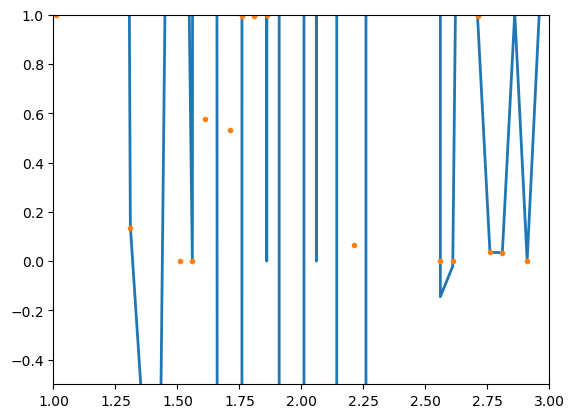

In [301]:
plt.plot(gamma_array, interpol.interp1d(gamma_array, prof_range, kind='cubic')(gamma_array), lw=2); 
plt.plot(gamma_array, prof_range, '.');
#plt.plot(gamma_array, prof_range2, '--');
plt.ylim(-0.5,1);
plt.xlim(1,3);

(1.0, 2.0)

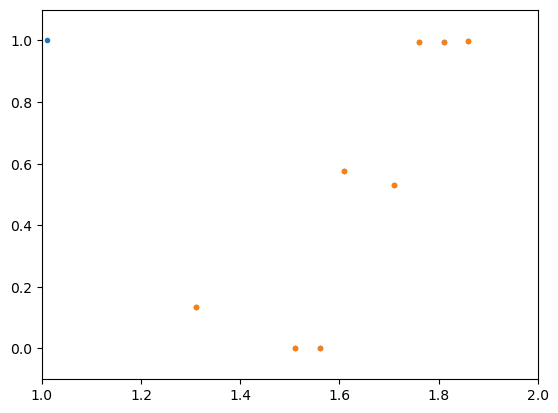

In [237]:
plt.plot(gamma_array, prof_range, '.');
plt.plot(gamma_array, prof_range2, '.');
plt.ylim(-0.1,1.1);
plt.xlim(1,2)

In [151]:
i = 0
for j in bd_real[0]:
    print(bd_real_noInterp[0,i]/bd_real[0,i])
    i+=1

#bd_real_noInterp == bd_real*(bd_real_noInterp/bd_real) # 0.01440155

0.01440155336670272
0.014401553366702718
0.014401553366702716
0.01440155336670272
0.014401553366702716
0.014401553366702718
0.014401553366702718
0.014401553366702718
0.014401553366702718
0.014401553366702718
0.014401553366702716
0.014401553366702716
0.014401553366702716
0.01440155336670272
0.014401553366702716
0.01440155336670272
0.014401553366702716
0.014401553366702716
0.014401553366702718
0.014401553366702718
0.014401553366702718
0.01440155336670272
0.014401553366702718
0.014401553366702716
0.014401553366702718
0.014401553366702718
0.01440155336670272
0.014401553366702718
0.01440155336670272
0.014401553366702716
0.014401553366702718
0.01440155336670272
0.014401553366702718
0.014401553366702716
0.014401553366702716
0.014401553366702718
0.014401553366702716
0.014401553366702716
0.014401553366702716
0.014401553366702716
0.014401553366702716
0.014401553366702716
0.014401553366702718
0.014401553366702716
0.014401553366702718
0.014401553366702716
0.014401553366702718
0.014401553366702718


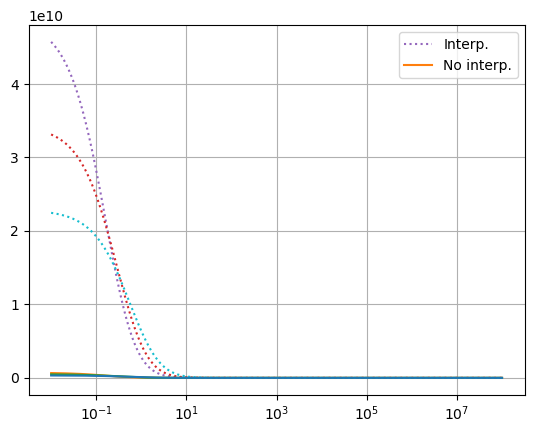

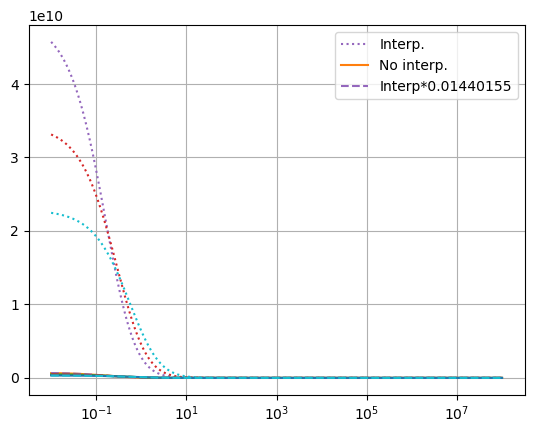

In [117]:
colour1, colour2 = ['tab:purple','tab:red','tab:cyan'], ['tab:orange','tab:green','tab:blue']
for mass, col1, col2, interp, nointerp in zip(trial_M, colour1, colour2, bd_real, bd_real_noInterp):
    plt.plot(trial_r, interp, ':', color=col1)#, label=f'Interpolated: {mass:.1g} $M \\odot $')
    plt.plot(trial_r, nointerp, color=col2)#, label=f'No interp.: {mass:.1g} $M \\odot $');
plt.legend(['Interp.', 'No interp.'], loc='best')
plt.grid(True)
plt.xscale('log');

plt.figure()
for mass, col1, col2, interp, nointerp in zip(trial_M, colour1, colour2, bd_real, bd_real_noInterp):
    plt.plot(trial_r, interp, ':', color=col1)#, label=f'Interpolated: {mass:.1g} $M \\odot $')
    plt.plot(trial_r, nointerp, color=col2)#, label=f'No interp.: {mass:.1g} $M \\odot $');
    plt.plot(trial_r, interp*(0.01440155), '--', color=col1)#, label=f'Interpolated*5.2732215 : {mass:.1g} $M \\odot $')
plt.legend(['Interp.', 'No interp.', 'Interp*0.01440155'], loc='best')
plt.grid(True)
plt.xscale('log');

In [97]:
print(bd_real[0])
print(bd_real_noInterp[0])
print(profTrial_interpd_real[0])
print(profTrial_real[0])

[4.57229335e+10 4.57222908e+10 4.57216480e+10 ... 7.02715030e-13
 7.02235062e-13 7.01755422e-13]
[6.58481266e+08 6.58472011e+08 6.58462753e+08 ... 1.01201880e-14
 1.01132757e-14 1.01063682e-14]
[4.57229335e+10 4.57222908e+10 4.57216480e+10 ... 7.02715030e-13
 7.02235062e-13 7.01755422e-13]
[6.58481266e+08 6.58472011e+08 6.58462753e+08 ... 1.01201880e-14
 1.01132757e-14 1.01063682e-14]


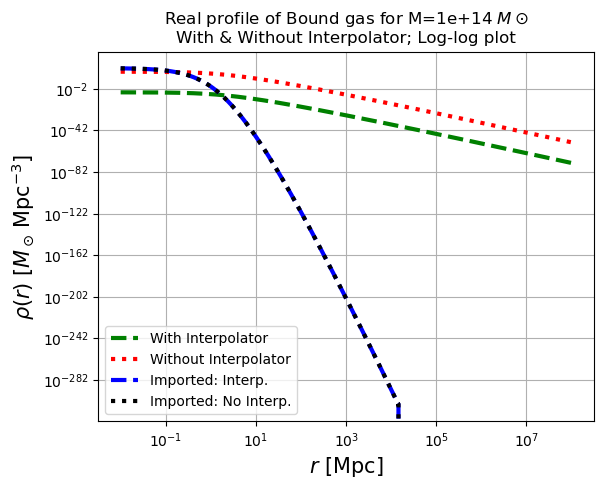

In [340]:
plt.plot(trial_r, profTrial_interpd_real[2], 'g--', lw=3, label='With Interpolator')
plt.plot(trial_r, profTrial_real[2], 'r:', lw=3, label='Without Interpolator')

plt.plot(trial_r, bd_real[2], 'b--', lw=3, label='Imported: Interp.')
plt.plot(trial_r, bd_real_noInterp[2], 'k:', lw=3, label='Imported: No Interp.')

plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(f'Real profile of Bound gas for M={trial_M[2]:.1g} $M\\odot $\nWith & Without Interpolator; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log'); 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


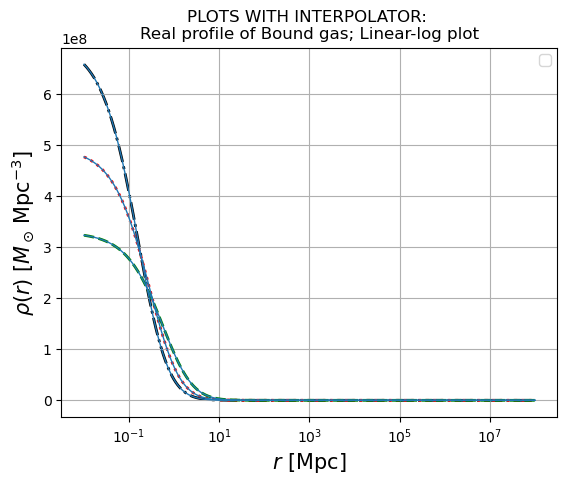

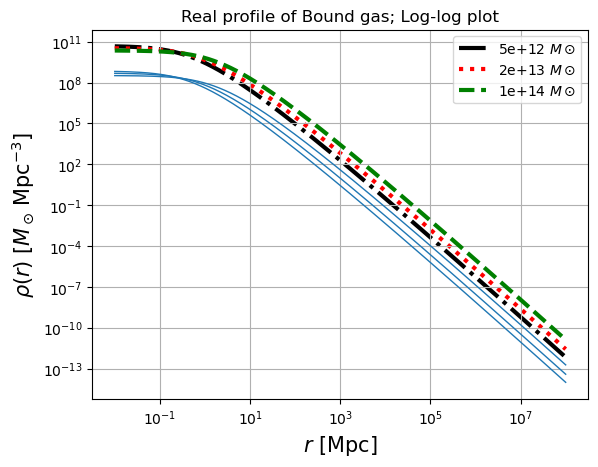

In [119]:
colours, i = ['k-.', 'r:', 'g--'], 0
for j, col in zip(trial_M, colours):
   # plt.plot(trial_r, profTrial_interpd_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    plt.plot(trial_r, profTrial_real[i], color='tab:blue', lw=1, zorder = 10-i)
    plt.plot(trial_r, (0.01440155)*profTrial_interpd_real[i], col, lw=2, zorder = i)
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('PLOTS WITH INTERPOLATOR: \nReal profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, profTrial_interpd_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    plt.plot(trial_r, profTrial_real[i], color='tab:blue', lw=1, zorder = 10-i)
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Bound gas; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

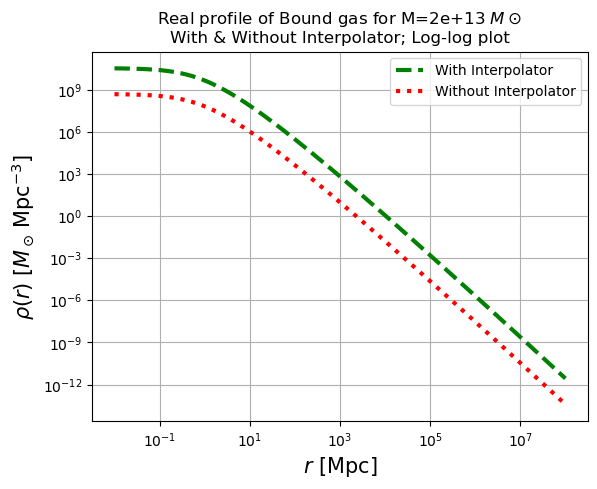

In [102]:
plt.plot(trial_r, bd_real[1], 'g--', lw=3, label='With Interpolator')
plt.plot(trial_r, bd_real_noInterp[1], 'r:', lw=3, label='Without Interpolator')
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(f'Real profile of Bound gas for M={trial_M[1]:.1g} $M\\odot $\nWith & Without Interpolator; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log'); 